# 期货品种选择

In [2]:
import sys
sys.path.append('C:\\Users\\xpy\\work\\strategies2py\\AprilQuant')
 
import pandas as pd
import seaborn as sns

from backtest.return_rate_calculations import (
    cal_avg_cum_ret, 
    avg_cum_ret_from_cursor, 
    standardize
)
from backtest.tester import Tester
from utils import query, plot_curves, select_by_quantile
from consts import C_DAILY


Tester.read_cache('daily')
sns.set_style('darkgrid')
PARAMS = dict(length=60, ema_length=150, trs=0.12, lqk_width=0.1, lqk_floor=0.5)

# 各品种累计收益率
CUM_RET_DICT = dict()
for c in C_DAILY:
    cursor = query('C73', 'daily', category=c, **PARAMS)
    CUM_RET_DICT[c] = avg_cum_ret_from_cursor(cursor)

    
def is_across(df, time):
    """行情的起止日期是否跨过time"""
    return df['datetime'].iloc[0] < time and df['datetime'].iloc[-1] > time   


def select_between(df, time0, time1):
    """选择一段time0至time1的行情"""
    return df[(time0 < df.datetime) & (df.datetime <= time1)]
    

    
def dynamicly_choose_category(freq: str, sort_fn: "<class 'function'>", quantile:tuple=(0, 0.2), start='2010-01-01', end='2022-01-01'): 
    """
    将整个回测区间分为若干个周期，用前一个周期的数据将品种排序并选出某个分位数上的品种，
    在下一期选择该品种，滚动地构建出一条收益率曲线。
    
    params:
        - freq: 持仓调整频率。
        - sort_fn：使用历史数据将品种排序的某种规则。
        - quantile: 选出的品种排序后的分位数。
        - start: 回测开始日期
        - end: 回测结束日期
    """
    # 调仓时间
    times = pd.date_range(start=start, end=end, freq=freq).to_pydatetime()
    
    avg_cum_rets = []
    for pre_t, t, next_t in zip(times[:-2], times[1:-1], times[2:]):
        
        # 选择在历史期和预测期的都有行情的品种, 及它们在历史期的行情
        # pre_t 到 t 为历史期, t 到 next_t为预测期。
        history_data = {
            c: select_between(df, pre_t, t) 
            for c, df_list in Tester.backtest_data.items()
            for df in df_list if is_across(df, t)
        }
        
        # 根据选取规则选择品种以及它们在预测期的平均收益率（预测期不包括下一个调仓日期）
        sorted_categories = sorted(history_data.keys(), 
                                   key=lambda c: sort_fn(history_data[c]), 
                                   reverse=True)
        selected_categories = select_by_quantile(sorted_categories, quantile[0], quantile[1])
        future_cum_rets = filter(
            lambda x: len(x) > 0, 
            [CUM_RET_DICT[c].loc[t: next_t] for c in selected_categories]
        )
        
        # 将收益率曲线标准化, 并去除第一项避免与上一期重复
        future_cum_rets = [standardize(cr).iloc[1:] for cr in future_cum_rets]
        avg_cum_ret = cal_avg_cum_ret(future_cum_rets)
        avg_cum_rets.append(avg_cum_ret)
    
    # todo；在拼接累计收益率曲线时考虑换仓交易成本
    return cal_avg_cum_ret(avg_cum_rets)

## 1. 基准收益率
不做任何品种筛选的累计收益率曲线。

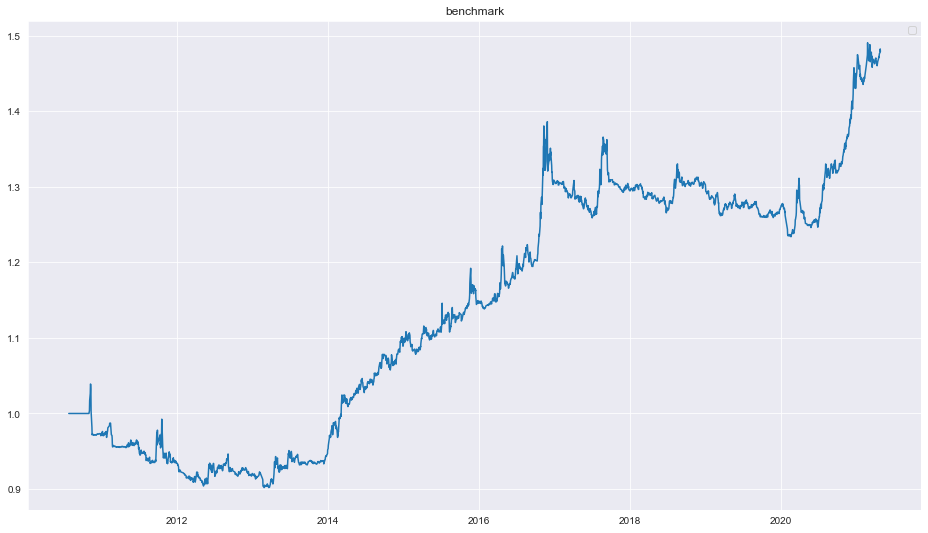

In [4]:
benchmark = cal_avg_cum_ret(CUM_RET_DICT.values())
plot_curves([benchmark], 'benchmark', [])

## 2. 构建选择标准

In [3]:
freqs = ['180D', '360D', '540D']
quantiles = [(0, 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, 1.0)]

## 2.1 最近交易量占历史交易量比重
最近一段时间成交量占比更大，是否说明最近行情有更显著的趋势？

将调仓频率设为180天，360天， 540天，进行分位数测试，未能证实成交量占比对收益率的预测能力。

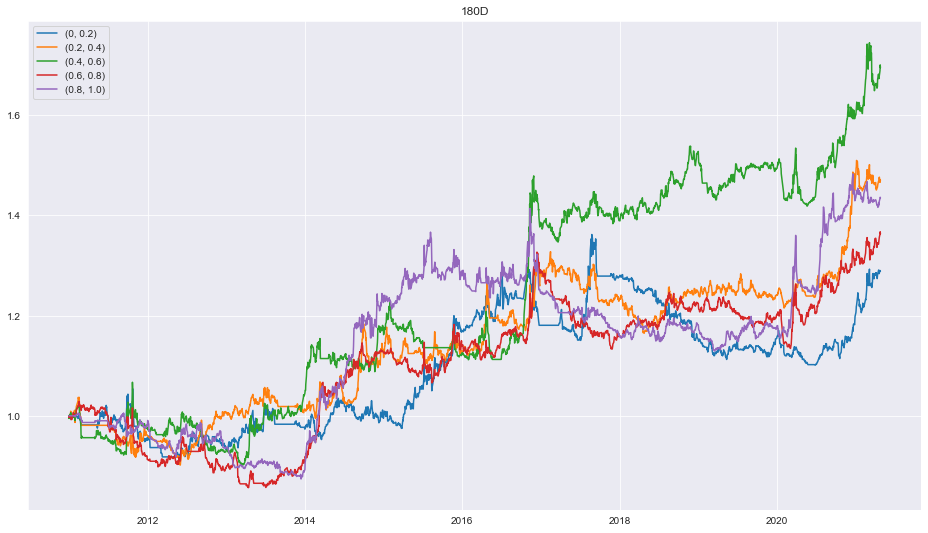

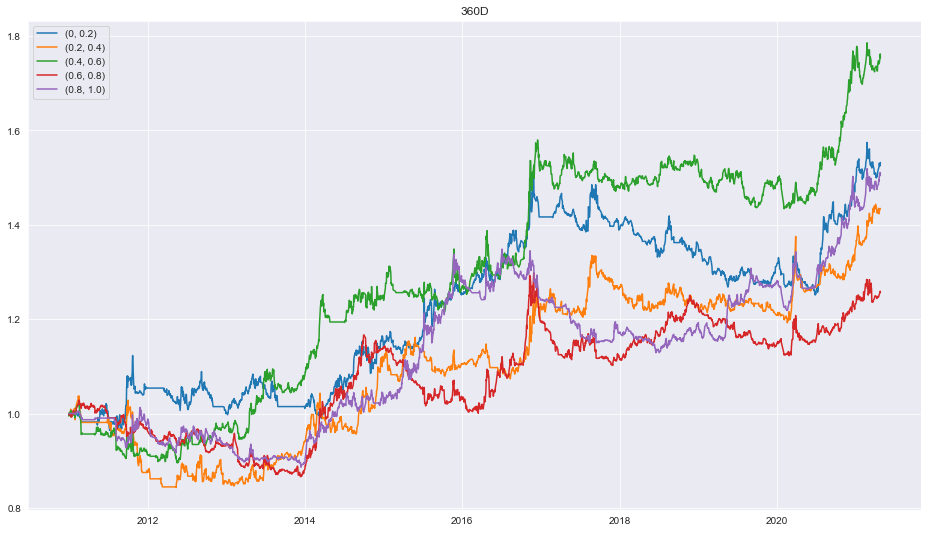

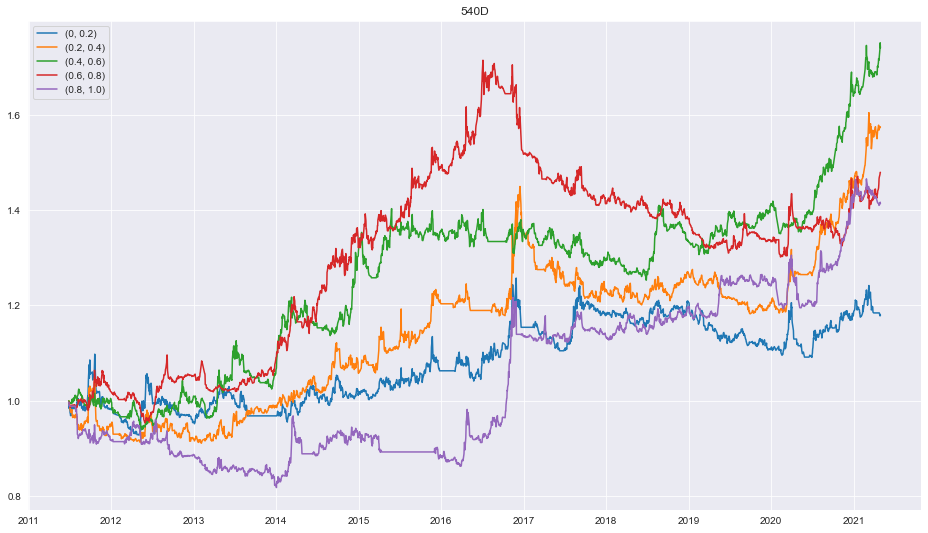

In [52]:
def volume_recent_to_all(df, recent=1/6):
    """计算最近一段时间的成交量占总体的比重"""
    recent_length = int(len(df) * recent)
    recent_v = df.volume.iloc[-recent_length:]
    all_v = df.volume
    return recent_v.sum() / all_v.sum()


for freq in freqs:
    cum_ret_by_quantile = [dynamicly_choose_category(freq=freq, 
                                                     sort_fn=volume_recent_to_all, 
                                                     quantile=quantile) 
                           for quantile in quantiles]
    plot_curves(cum_ret_by_quantile, freq, quantiles)

## 2.2 最近交易量偏离过去均值
类似地，最近一段时间成交量均值偏离过去平均水平越多，是否说明最近行情有更显著的趋势？

将调仓频率设为180天，360天， 540天，进行分位数测试，未能证实成交量偏离对收益率的预测能力。

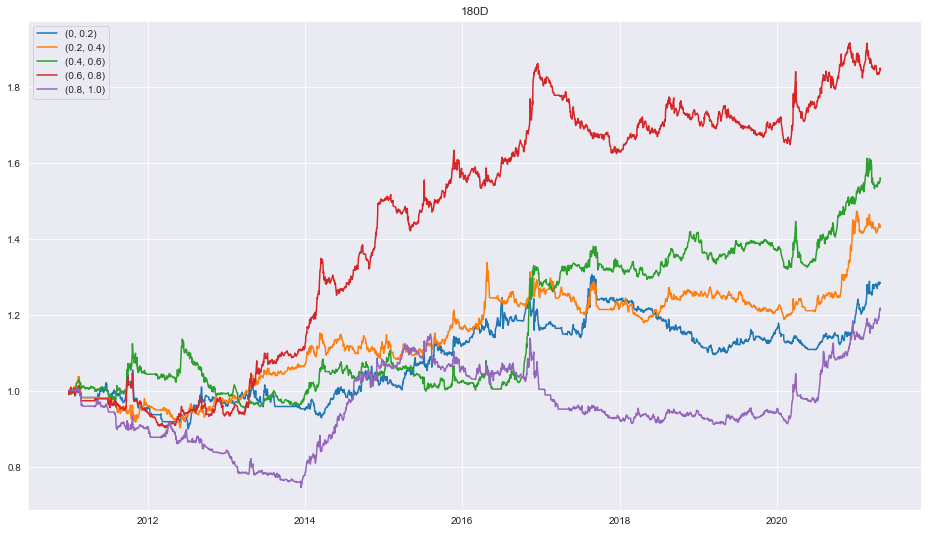

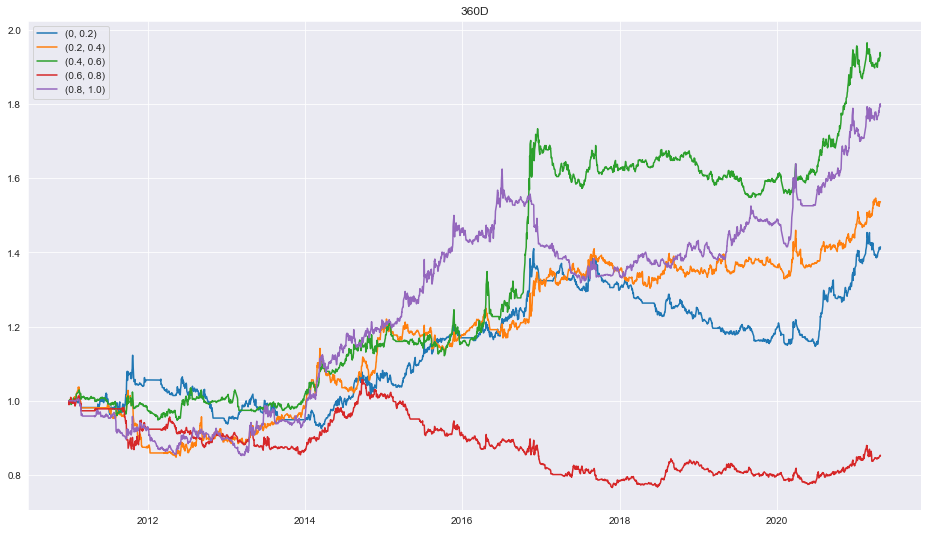

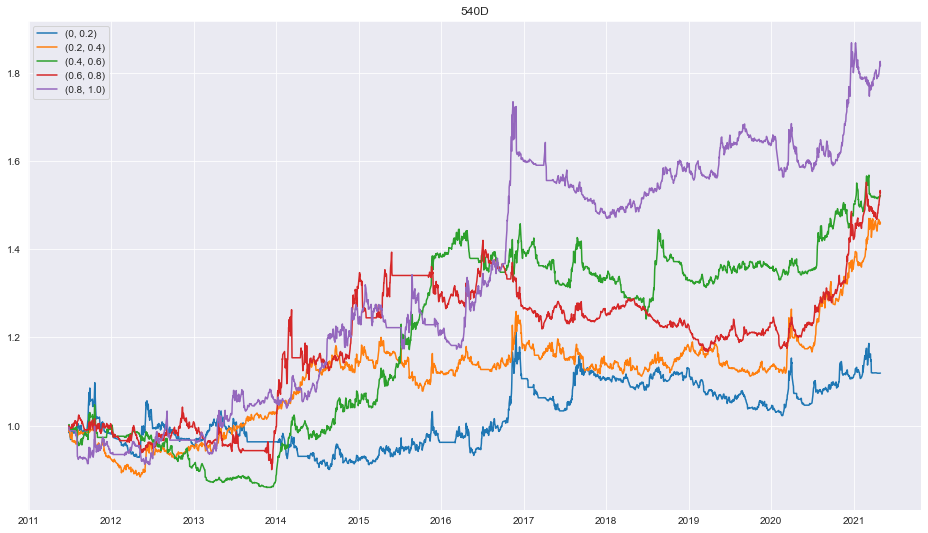

In [23]:
def volume_recent_deviation(df, recent=1/6):
    """计算最近一段时间的成交量与整体成交量的偏离程度"""
    recent_length = int(len(df) * recent)
    recent_v = df.volume.iloc[-recent_length:]
    prev_v = df.volume.iloc[:-recent_length]
    return (recent_v.mean() - prev_v.mean()) / prev_v.std()


for freq in freqs:
    cum_ret_by_quantile = [dynamicly_choose_category(freq=freq, 
                                                     sort_fn=volume_recent_deviation, 
                                                     quantile=quantile) 
                           for quantile in quantiles]
    plot_curves(cum_ret_by_quantile, freq, quantiles)

## 2.3 复权价格涨幅
将过去一期复权价格涨幅作为分组标准进行分位数测试

将调仓频率设为180天，360天， 540天，进行分位数测试，涨幅最小的品种反而能在下一期有更好的表现。

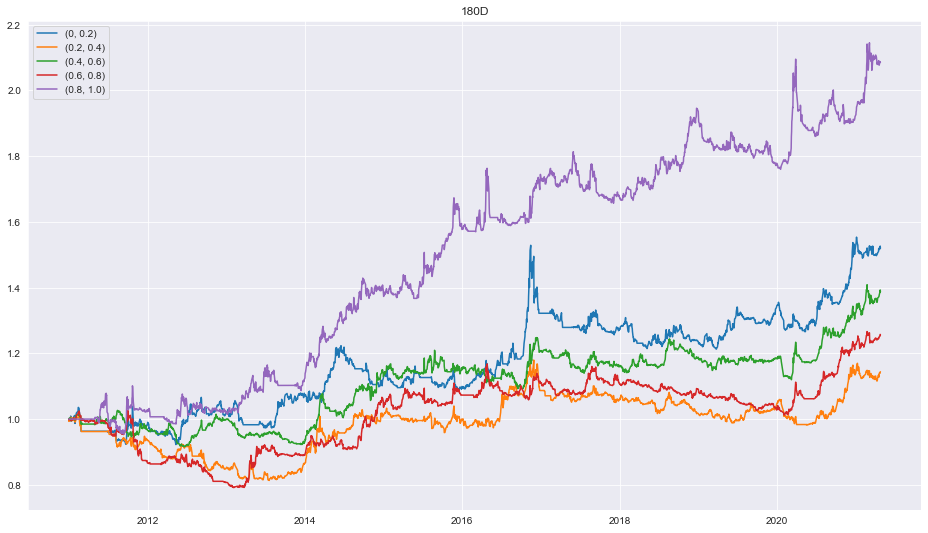

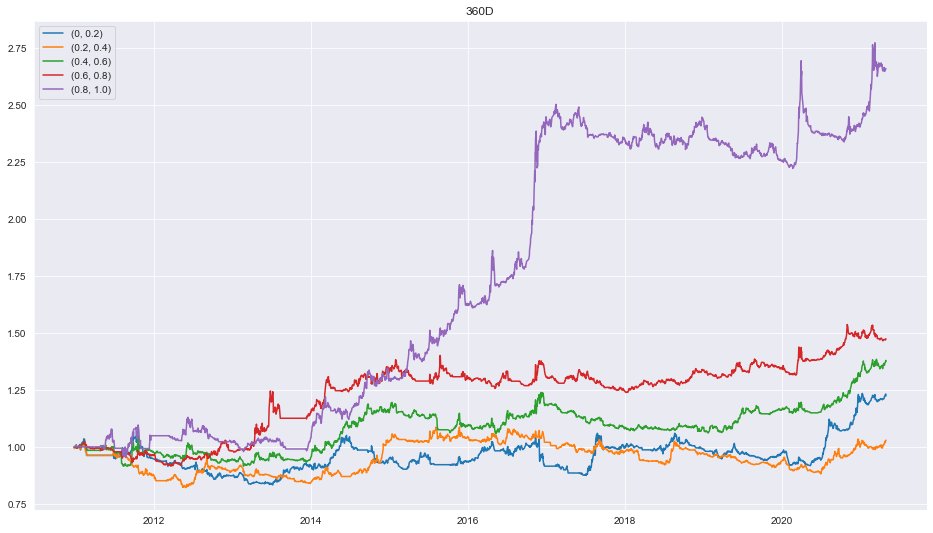

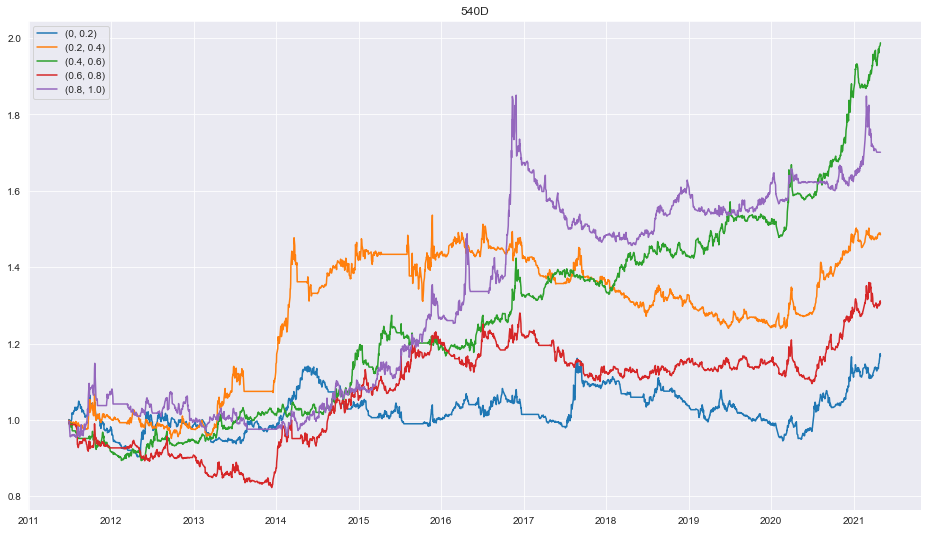

In [5]:
def return_rate(df):
    """计算品种收益率"""
    return df.adjusted_close.iloc[-1] / df.adjusted_close.iloc[0] - 1


for freq in freqs:
    cum_ret_by_quantile = [dynamicly_choose_category(freq=freq, 
                                                     sort_fn=return_rate, 
                                                     quantile=quantile) 
                           for quantile in quantiles]
    plot_curves(cum_ret_by_quantile, freq, quantiles)